In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil.parser import parse
from utils import mean_2d_diff_size

In [2]:
LOGS_PATH = "../logs/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'batch_100' in f and 'epochs_1000' in f and 'json' in f]

In [3]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data[field] = data[field].apply(parse)
data['compute-time'] = (data['end-compute-time'] - data['start-compute-time'])/np.timedelta64(1, 's')

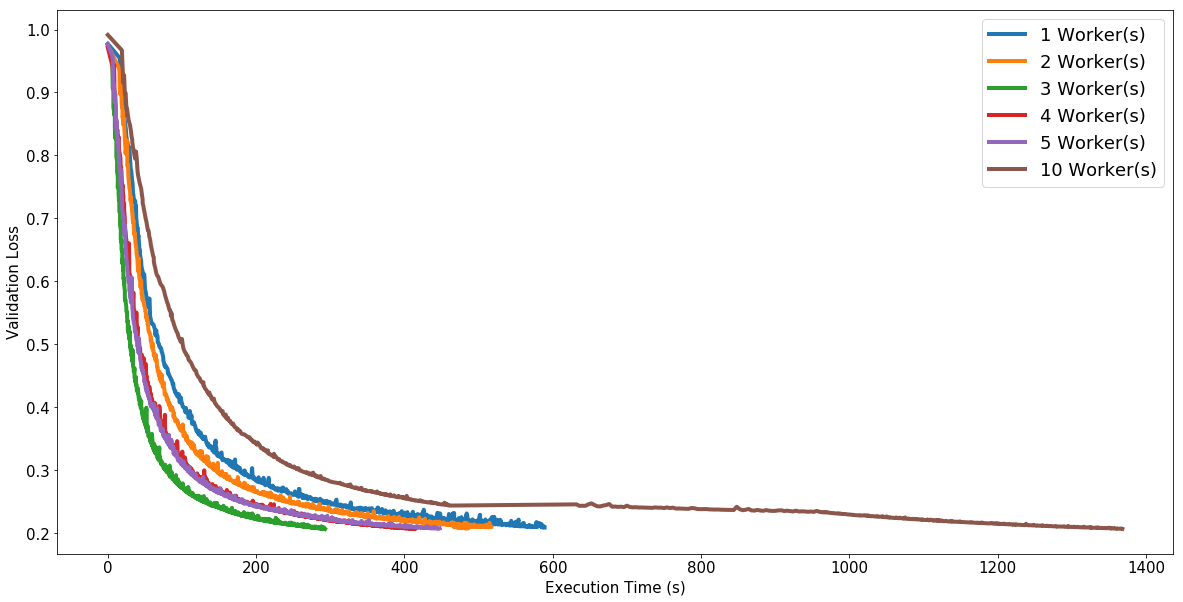

In [7]:
by_workers = data.groupby('num_workers')
plt.figure(figsize=(20,10))
for i in by_workers:
    epoch_history = i[1]['epochs-stats'].values
    worker_ttstamps = []
    worker_losses = []
    for stat in epoch_history:
        start_time = parse(stat[0]['epoch_start'])
        #list of timestamps for this run
        time_stamps = [(parse(epoch['epoch_start']) - start_time).seconds for epoch in stat]
        worker_ttstamps.append(time_stamps)
        
        #list of losses for this run
        losses = [epoch['val_loss'] for epoch in stat]
        worker_losses.append(losses)
    
    #average this shit
    mean_worker_ttstamps = mean_2d_diff_size(worker_ttstamps)
    mean_losses = mean_2d_diff_size(worker_losses)
    plt.plot(mean_worker_ttstamps, mean_losses, '-', label="{} Worker(s)".format(i[0]), linewidth=4)
plt.xlabel('Execution Time (s)')
plt.ylabel('Validation Loss')
plt.rc('font', size=18)
plt.legend()
plt.show()

### Read Hogwild!

In [8]:
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'hogwild' in f and 'json' in f]

In [9]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data_hog = pd.concat(logs, axis=0)

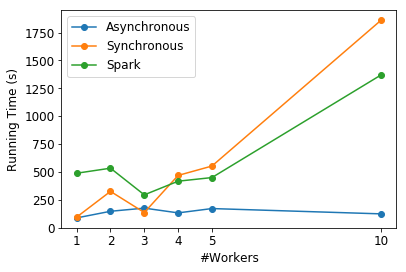

In [13]:
### Hogwild
by_sync = data_hog.groupby('running_mode')
for rmode in by_sync:
    mode = rmode[0]
    times = []
    workers = []
    for w_count in rmode[1].groupby('n_workers'):
        work = int(w_count[0])
        workers.append(work)
        time = np.mean(w_count[1]['running_time'].values)
        times.append(time)
    zipped_sorted = sorted(zip(workers, times), key=lambda x: x[0])
    (workers, times) = zip(*zipped_sorted)
    plt.plot(workers, times, 'o-', label=mode.capitalize())

### Spark
by_workers = data.groupby('num_workers')
times = []
workers = []
for i in by_workers:
    compute_time = i[1]['compute-time']
    workers.append(i[0])
    times.append(np.mean(compute_time))

plt.plot(workers, times, 'o-', label='Spark')
### plot
plt.rc('font', size=12)
plt.xlabel('#Workers')
plt.ylabel('Running Time (s)')
plt.xticks(workers)
plt.legend()
plt.show()


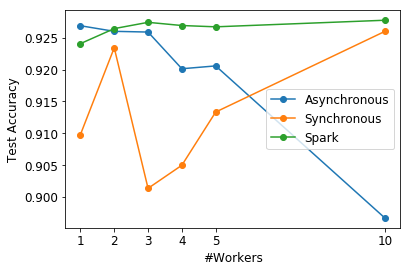

In [14]:
### Hogwild
by_sync = data_hog.groupby('running_mode')
for rmode in by_sync:
    mode = rmode[0]
    accs = []
    workers = []
    for w_count in rmode[1].groupby('n_workers'):
        work = int(w_count[0])
        workers.append(work)
        acc = np.mean(w_count[1]['accuracy_test'].values)
        accs.append(acc)
    zipped_sorted = sorted(zip(workers, accs), key=lambda x: x[0])
    (workers, accs) = zip(*zipped_sorted)
    plt.plot(workers, accs, 'o-', label=mode.capitalize())

    
### Spark
by_workers = data.groupby('num_workers')
test_accs = []
workers = []
for i in by_workers:
    acc = np.array(i[1]['test_accuracy'].values)
    workers.append(i[0])
    test_accs.append(np.mean(acc))
plt.plot(workers, test_accs, 'o-', label="Spark")

### General plot info
plt.rc('font', size=12)
plt.xlabel('#Workers')
plt.ylabel('Test Accuracy')
plt.xticks(workers)
plt.legend()
plt.show()